## 1. Imports
---

In [30]:
import os
import random
import re
import json
import csv
from pathlib import Path
import torch
from torchinfo import summary
from preprocessing_utils import prepare_images, summarize_split, preview_random_images, get_dataloaders, show_batch
from models_utils import train_model, test_model, plot_confusion_matrix, plot_training_process, predict_image
from mlp import MLPBaseline

In [2]:
print(torch.__version__)
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2.8.0+cpu
Using device: cpu


## 2. Getting Images Ready
---

The dataset used in this project is the Chinese MNIST dataset, which contains images of handwritten Chinese numerals (digits 0-9) written by multiple individuals. Each image is labeled with its corresponding digit and additional label. The dataset is organized as follows:
- **Images**: Located in the `data/c_mnist` folder, each image file is named according to its suite, sample, and code.
- **Labels**: Provided in the `data/chinese_mnist.csv` file, which includes the digit value, character, and code for each image.

In this section, the following steps are performed:
1. **Download and Extraction**: The dataset is downloaded (if not already present) and extracted to the `data` directory.
2. **Splitting**: The images are split into training, validation, and test sets according to a specified ratio, with each split organized into subfolders by class.
3. **Summary and Preview**: The script prints a summary of the number of images and classes in each split, and displays a random sample of images from the dataset for visual inspection.

The default ratio is training 80%, validation 10% and testing 10%.

In [3]:
root = prepare_images()
print(f"Dataset ready at: {root}")

Dataset already exists, skipping download.
Train/Val/Test folders already exist. (Set overwrite=True to recreate them)
Dataset ready at: data


In [4]:
summarize_split(str(root))

train: 12000 images, 15 classes
{'0': 800, '1': 800, '10': 800, '100': 800, '1000': 800, '10000': 800, '100000000': 800, '2': 800, '3': 800, '4': 800, '5': 800, '6': 800, '7': 800, '8': 800, '9': 800}
val: 1500 images, 15 classes
{'0': 100, '1': 100, '10': 100, '100': 100, '1000': 100, '10000': 100, '100000000': 100, '2': 100, '3': 100, '4': 100, '5': 100, '6': 100, '7': 100, '8': 100, '9': 100}
test: 1500 images, 15 classes
{'0': 100, '1': 100, '10': 100, '100': 100, '1000': 100, '10000': 100, '100000000': 100, '2': 100, '3': 100, '4': 100, '5': 100, '6': 100, '7': 100, '8': 100, '9': 100}


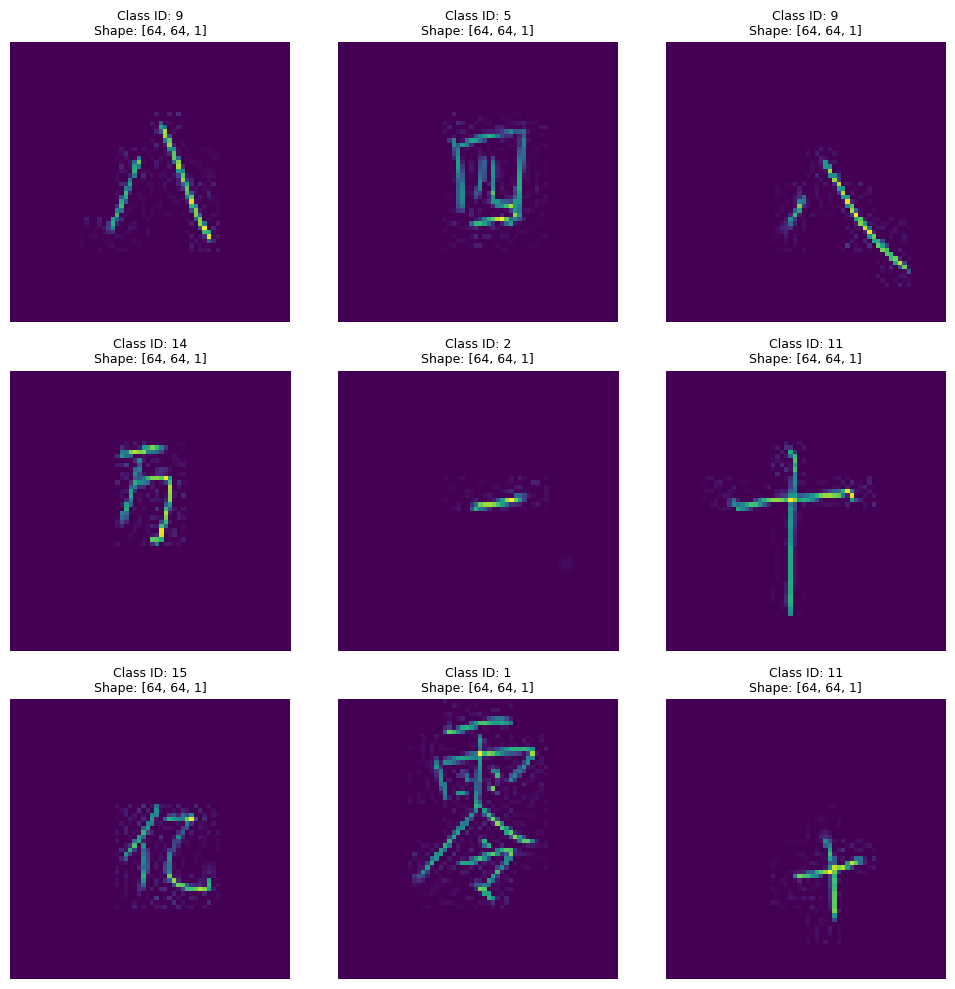

In [5]:
preview_random_images(data_dir=str(root / "c_mnist"), n_images=9, grid_size=(3, 3))

## 3. Preprocessing
---

This section prepares image tensors and DataLoaders used for training and evaluation.

What we do here:
- Always convert images to grayscale (1 channel) first, then resize to a fixed image_size (e.g., 64x64).
- Training-only augmentation (when augment=True): small random rotation (±10°) and RandomAffine with up to 5% translation. Validation and test receive no augmentation.
- Convert images to tensors with transforms.ToTensor() so pixel values are in [0, 1].
- Optional normalization (when normalize=True): applies transforms.Normalize((mean,), (std,)) for the single grayscale channel. Defaults are mean=0, std=1. Use the same mean/std for train/val/test when enabled.
- Optional flattening (when flatten=True): flattens the tensor to a 1-D vector via a Lambda step. Keep flatten=True for MLPs; set flatten=False for CNNs.
- The overall transform order is: Grayscale → Resize → [Augment (train only)] → ToTensor → [Normalize] → [Flatten].

How datasets and loaders are built:
- Create ImageFolder datasets from data/train, data/val, and data/test; class labels come from the subfolder names created in the previous step.
- Wrap datasets with PyTorch DataLoaders using the chosen batch_size. The training loader is shuffled; val/test are not.

Inputs / outputs:
- Inputs: images on disk under `data/{train,val,test}`.
- Outputs: `dataloaders` and `datasets` dicts where `dataloaders['train']` yields (X, y) batches ready for training.

Notes:
- Normalization is off by default. Enable normalize=True to get zero-mean/unit-variance inputs based on the provided mean/std (single-channel).
- Augmentation is intentionally light to preserve digit structure; adjust or disable as needed.
- If splits are missing, call prepare_images(overwrite=False) to (re)create them.

In [6]:
dataloaders, datasets = get_dataloaders(data_dir="data", batch_size=64, image_size=(64, 64), augment=True)
labels = datasets['train'].classes
print("DataLoaders ready.")
print(f"Classes: {labels}")

DataLoaders ready.
Classes: ['0', '1', '10', '100', '1000', '10000', '100000000', '2', '3', '4', '5', '6', '7', '8', '9']


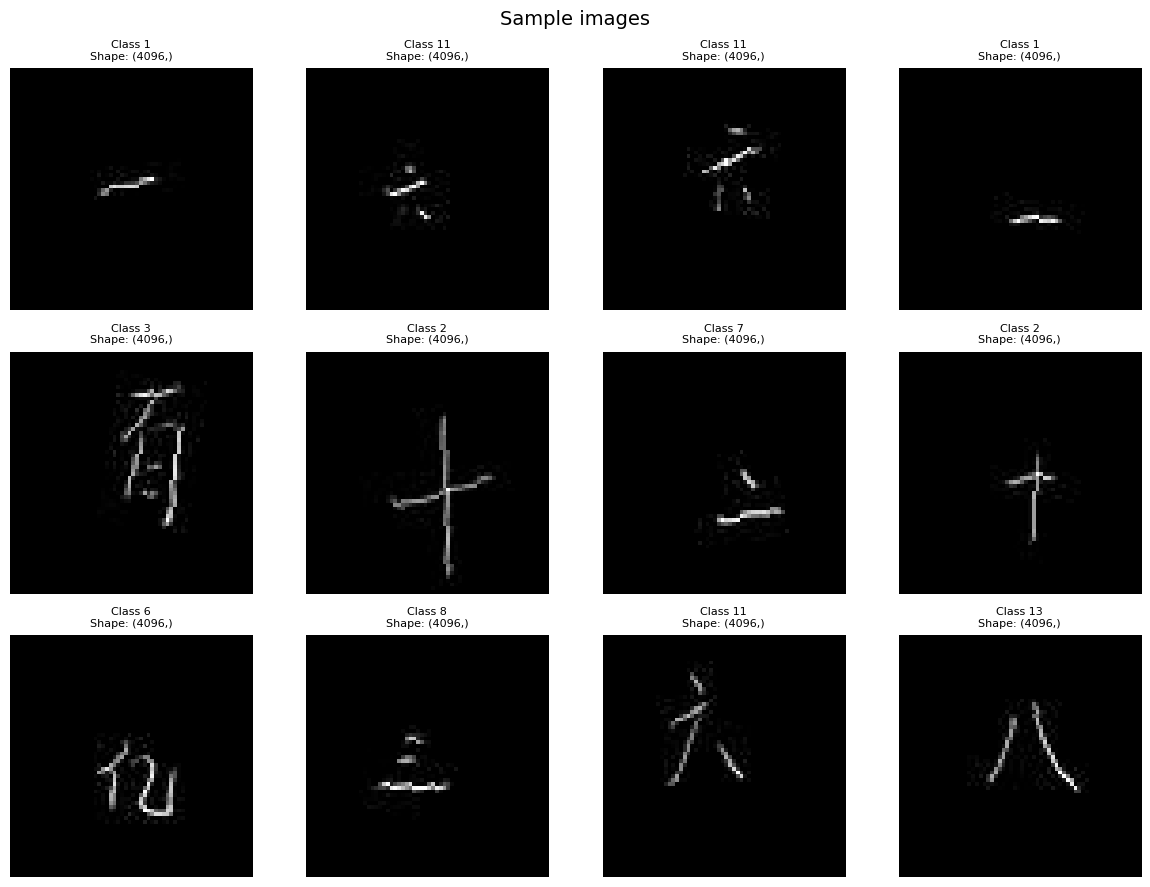

In [7]:
show_batch(datasets['train'], n=12, cols=4)

## 4. Parameters and Architectures
---

We now use a configurable **Multi-Layer Perceptron (MLP)** to classify Chinese MNIST digits. Images are 64×64 grayscale and flattened to 4096 input features. The task has **15 classes** (based on the chosen labeling scheme during dataset preparation).

#### Core Training Hyperparameters

- **INPUT_DIM = 64 * 64 (4096)**  
  Flattened size of each grayscale image. The MLP expects a 1D vector per sample. Flattening happens in the preprocessing transforms when `flatten=True`.
- **NUM_CLASSES = 15**  
  Output layer size; the model returns logits of shape `(batch_size, 15)` consumed by `CrossEntropyLoss`.
- **BATCH_SIZE = [32, 256]**  
  We evaluate both a smaller and a larger batch size. Small batches introduce gradient noise (potentially better generalization); large batches are computationally efficient and yield smoother updates.
- **EPOCHS = 50**  
  Upper bound for training. Early stopping (via `PATIENCE`) prevents over-training when validation accuracy plateaus.
- **LEARNING_RATE = [0.01, 0.001, 0.0005]**  
  A coarse-to-fine sweep: high (0.01) for rapid progress, mid (0.001) for stability, and low (0.0005) for fine convergence—tested for BOTH optimizers.
- **WEIGHT_DECAY = 5e-4**  
  Acts as L2 regularization on weights; helps prevent overfitting on fully-connected layers which can easily memorize pixel-level noise.
- **MOMENTUM = 0.9 (SGD only)**  
  Speeds up traversal across ravines and dampens oscillations. Traditional and effective default for vision tasks.
- **PATIENCE = 5**  
  If validation accuracy does not improve for 5 consecutive epochs, training stops early and the best checkpoint is kept.

#### Architecture Search Parameters

Instead of a single fixed layout, we explore multiple MLP configurations. Each architecture is encoded in a descriptive name and saved to disk using a consistent pattern.

- **MLP_HIDDEN_LAYERS = [1, 2, 3, 4]**  
  Depth controls representational hierarchy. Too shallow → underfit; too deep for this dataset → diminishing returns / overfit.
- **MLP_HIDDEN_UNITS = [1024, 512, 256, 128]**  
  Candidate widths for layers. Wider early layers allow rich feature mixing; later shrinking layers encourage abstraction and compression.
- **DROPOUT_RATE = 0.5**  
  Applied after each hidden layer to reduce co-adaptation and mitigate overfitting, especially important in dense networks without spatial inductive bias.

#### Architecture Set (`architectures` list)

Example entries (shown later in code):  
- `mlp_1x512` → 1 hidden layer of 512 units  
- `mlp_2x256` → 2 hidden layers, each 256 units (symmetric)  
- `mlp_3x512-256-128` → 3 hidden layers of decreasing width  
- (You can easily extend with `mlp_4x1024-512-256-128`)

Each name encodes:  
`mlp_{depth}x{unitsPattern}` where `unitsPattern` is either a single integer (repeated width) or a hyphen-separated list of layer sizes.

#### Checkpoint Naming Convention

During training we save best-validation checkpoints per (architecture, batch size, optimizer, learning rate):  
```
checkpoints/mlp/{architecture_name}_{batch_size}_{optimizer}_{learning_rate}.pth
# Example: checkpoints/mlp/mlp_3x512-256-128_32_adam_0.001.pth
```
If an optimizer segment is absent (fallback cases), filenames still follow the prefix and structural pattern.

#### Summary

| Category | Key Choices | Justification |
|----------|-------------|---------------|
| Input | Flattened 64×64 grayscale | Simplifies model to dense layers |
| Depth | 1–4 layers | Explore capacity vs overfit |
| Width | 1024→128 progression | Wide early abstraction, tapered compression |
| Regularization | Dropout 0.5, weight decay 5e-4 | Prevent overfitting in dense nets |
| Optimizers | Adam, SGD+Momentum | Compare adaptive vs classical momentum |
| LR Sweep | 0.01 / 0.001 / 0.0005 | Coarse → fine convergence control |
| Early Stop | Patience 5 | Efficiency & generalization |
| Persistence | JSON + CSV per run | Reproducible offline analysis |
| Naming | `mlp_{depth}x{units}` | Transparent architecture encoding |

In [8]:
sample_batch = next(iter(dataloaders["train"]))[0]
# For flattened 64x64 images
INPUT_DIM = sample_batch.shape[1] if sample_batch.ndim == 2 else sample_batch[0].numel()
NUM_CLASSES = len(labels)

BATCH_SIZE = [32, 256]
EPOCHS = 50
PATIENCE = 5
LEARNING_RATE = [0.01, 0.001, 0.0005]
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9 # For SGD

MLP_HIDDEN_LAYERS = [1, 2, 3, 4]
MLP_HIDDEN_UNITS = [1024, 512, 256, 128]
DROPOUT_RATE = 0.5

We define ranges for batch size, learning rate, hidden layers, and hidden units to allow hyperparameter search to find the best combination. Other parameters are fixed based on common defaults and prior experience with similar tasks. These are the architectures we will explore:

In [9]:
architectures = [
    {"name": "mlp_1x512", "hidden_layers": MLP_HIDDEN_LAYERS[0], "hidden_units": MLP_HIDDEN_UNITS[1], "dropout": DROPOUT_RATE},
    {"name": "mlp_2x256", "hidden_layers": MLP_HIDDEN_LAYERS[1], "hidden_units": MLP_HIDDEN_UNITS[2], "dropout": DROPOUT_RATE},
    {"name": "mlp_3x512-256-128", "hidden_layers": MLP_HIDDEN_LAYERS[2], "hidden_units": MLP_HIDDEN_UNITS[1:], "dropout": DROPOUT_RATE}
]

## 5. Loss and Optimizer
---

**Loss**

The standard loss for multi-class classification is **Cross-Entropy Loss** (`nn.CrossEntropyLoss` in PyTorch). This loss measures the difference between the predicted class probabilities (from model logits) and the true class labels. It combines a softmax activation with negative log-likelihood, encouraging the model to assign high probability to the correct class and penalizing incorrect predictions. Cross-entropy is robust, differentiable, and well-suited for tasks where each input belongs to exactly one of several classes, such as digit recognition.

**Optimizers**

**Stochastic Gradient Descent (SGD)** updates model parameters by moving them in the direction that reduces the loss, using gradients computed from random mini-batches of data. This introduces beneficial noise, helping the optimizer escape local minima and improving generalization. SGD is simple, memory-efficient, and, when combined with momentum, can accelerate convergence and smooth parameter updates. However, it requires careful tuning of the learning rate and may converge slowly, especially on problems with complex or poorly scaled loss surfaces.

**Adam (Adaptive Moment Estimation)** extends SGD by maintaining running averages of both the gradients and their squared values for each parameter, enabling adaptive learning rates. Adam typically converges faster and is less sensitive to the initial learning rate, making it robust and easy to use for a wide range of problems. It is especially effective for large datasets and high-dimensional parameter spaces.

In [28]:
# Model definition
mlp_model = MLPBaseline(input_dim=INPUT_DIM, num_classes=NUM_CLASSES, hidden_layers=MLP_HIDDEN_LAYERS[2], hidden_units=MLP_HIDDEN_UNITS[1:], dropout=DROPOUT_RATE)

# Loss and optimizers
criterion = torch.nn.CrossEntropyLoss()

## 6. Models Summary

In [29]:
print(f"MLP summary (input_dim={INPUT_DIM}, num_classes={NUM_CLASSES})")
summary(mlp_model, input_size=(1, INPUT_DIM), col_names=("input_size", "output_size", "num_params"))

MLP summary (input_dim=4096, num_classes=15)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MLPBaseline                              [1, 4096]                 [1, 15]                   --
├─Sequential: 1-1                        [1, 4096]                 [1, 15]                   --
│    └─Linear: 2-1                       [1, 4096]                 [1, 512]                  2,097,664
│    └─BatchNorm1d: 2-2                  [1, 512]                  [1, 512]                  1,024
│    └─ReLU: 2-3                         [1, 512]                  [1, 512]                  --
│    └─Dropout: 2-4                      [1, 512]                  [1, 512]                  --
│    └─Linear: 2-5                       [1, 512]                  [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  [1, 256]                  512
│    └─ReLU: 2-7                         [1, 256]                  [1, 256]                  --
│    └─Dropout: 2-8

## 7. Training

First, we are going to create different dataloaders for each batch size and training the model for each batch size.

In [12]:
dataloaders_dict = {}
for bs in BATCH_SIZE:
    dl, _ = get_dataloaders(data_dir="data", batch_size=bs, image_size=(64, 64), augment=True)
    dataloaders_dict[bs] = dl
    print(f"DataLoaders for batch size {bs} ready.")

DataLoaders for batch size 32 ready.
DataLoaders for batch size 256 ready.


#### Metrics Persistence

To enable offline analysis (without re‑running experiments), all **per‑epoch metrics** from every run are persisted immediately after training finishes.

**Artifacts written:**
- **Per‑run JSON** (directory: `metrics/mlp/`)  
  File name pattern: `{run_id}.json` where `run_id = {model_type}_bs{batch}_{optimizer}_lr{lr}` (dots in the LR replaced by underscores).  
  Contents include: model/architecture label, optimizer, batch size, learning rate, plus full epoch lists for: `train_accuracy`, `train_loss`, `val_accuracy`, `val_loss`.
- **Global detailed CSV**: `metrics/mlp/runs_detailed.csv`  
  A tidy, row‑wise log with one row per epoch across all runs. Columns:  
  `run_id, epoch, optimizer, batch_size, learning_rate, train_acc, train_loss, val_acc, val_loss`.

#### In‑Memory Metric Accumulators
During training we maintain dictionaries keyed by `(batch_size, learning_rate)` to hold the epoch sequences for each optimizer. This avoids recomputation and lets us generate plots after all runs finish.

For each optimizer (SGD, Adam) we store:
- `total_acc_train_*`: List of training accuracy values per epoch.
- `total_loss_train_*`: List of training loss values per epoch.
- `total_acc_validation_*`: List of validation accuracy values per epoch.
- `total_loss_validation_*`: List of validation loss values per epoch.

(“*” is either `_sgd` or `_adam`).

Each list length equals the number of completed epochs for that run (may be < `EPOCHS` if early stopping triggered). These structures feed the plotting utilities and are also passed to the persistence function right after a run concludes.

**Data Integrity Notes:**
- Persist is atomic per run: JSON then CSV append. If interrupted mid‑experiment, completed runs remain intact.  
- Re‑running the same configuration will overwrite the JSON for that `run_id` but append additional rows to the CSV (you can later filter duplicates by keeping only the max epoch per `run_id`).  
- Learning rates are string‑formatted in file names (with `.` swapped to `_`) to ensure filesystem safety.

**Quick Recap**
1. Train model with a (batch size, optimizer, learning rate) triple.  
2. Collect epoch curves in memory.  
3. Save JSON snapshot + append epoch rows to the global CSV.  
4. Use saved data later for plotting, model selection, reporting.

In [13]:
# Ensure metrics directory exists
os.makedirs("metrics/mlp", exist_ok=True)

def persist_run_metrics(model_type:str, optimizer_name:str, batch_size:int, lr:float,
                         acc_train, loss_train, acc_val, loss_val):
    """Persist per-epoch metrics for a single run to disk.
    Creates/updates:
      - JSON file with full metric lists
      - CSV row-wise log (one row per epoch)
    """
    run_id = f"{model_type}_bs{batch_size}_{optimizer_name}_lr{lr}".replace('.','_')
    base_dir = Path("metrics/mlp")
    base_dir.mkdir(parents=True, exist_ok=True)
    # JSON aggregate
    json_path = base_dir / f"{run_id}.json"
    payload = {
        "model": model_type,
        "optimizer": optimizer_name,
        "batch_size": batch_size,
        "learning_rate": lr,
        "train_accuracy": acc_train,
        "train_loss": loss_train,
        "val_accuracy": acc_val,
        "val_loss": loss_val,
    }
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(payload, f, indent=2)
    # CSV per-epoch (append)
    csv_path = base_dir / "runs_detailed.csv"
    file_exists = csv_path.exists()
    with open(csv_path, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["run_id","epoch","optimizer","batch_size","learning_rate","train_acc","train_loss","val_acc","val_loss"])
        for epoch_idx, (ta, tl, va, vl) in enumerate(zip(acc_train, loss_train, acc_val, loss_val), start=1):
            writer.writerow([run_id, epoch_idx, optimizer_name, batch_size, lr, ta, tl, va, vl])
    print(f"Metrics persisted for {run_id} -> {json_path}")

In [19]:
total_acc_train_sgd = {}
total_acc_validation_sgd = {}
total_loss_train_sgd = {}
total_loss_validation_sgd = {}

total_acc_train_adam = {}
total_acc_validation_adam = {}
total_loss_train_adam = {}
total_loss_validation_adam = {}

ARCHITECTURE_IDX = 2 # Change to select different architecture

for bs in BATCH_SIZE:
    print(f"\nTraining with batch size: {bs}")
    dataloaders = dataloaders_dict[bs]
    run_idx = 1
    for lr in LEARNING_RATE:
        # Adam run
        print(f"  Run {run_idx}: Adam optimizer with lr={lr}")
        model_adam = MLPBaseline(input_dim=INPUT_DIM, num_classes=NUM_CLASSES, hidden_layers=architectures[ARCHITECTURE_IDX]["hidden_layers"], hidden_units=architectures[ARCHITECTURE_IDX]["hidden_units"]).to(device)
        adam_opt = torch.optim.Adam(model_adam.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
        (
            acc_train_adam,
            loss_train_adam,
            acc_val_adam,
            loss_val_adam,
        ) = train_model(
            model_adam,
            dataloaders,
            adam_opt,
            criterion,
            epochs=EPOCHS,
            patience=PATIENCE,
            save_path=f"checkpoints/mlp/{architectures[ARCHITECTURE_IDX]['name']}_{bs}_adam_{lr}.pth",
        )
        total_acc_train_adam[(bs, lr)] = acc_train_adam
        total_loss_train_adam[(bs, lr)] = loss_train_adam
        total_acc_validation_adam[(bs, lr)] = acc_val_adam
        total_loss_validation_adam[(bs, lr)] = loss_val_adam
        persist_run_metrics(architectures[ARCHITECTURE_IDX]["name"], "adam", bs, lr, acc_train_adam, loss_train_adam, acc_val_adam, loss_val_adam)

        # SGD run
        print(f"  Run {run_idx}: SGD optimizer with lr={lr}, momentum={MOMENTUM}")
        model_sgd = MLPBaseline(input_dim=INPUT_DIM, num_classes=NUM_CLASSES, hidden_layers=architectures[ARCHITECTURE_IDX]["hidden_layers"], hidden_units=architectures[ARCHITECTURE_IDX]["hidden_units"]).to(device)
        sgd_opt = torch.optim.SGD(model_sgd.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        (
            acc_train_sgd,
            loss_train_sgd,
            acc_val_sgd,
            loss_val_sgd,
        ) = train_model(
            model_sgd,
            dataloaders,
            sgd_opt,
            criterion,
            epochs=EPOCHS,
            patience=PATIENCE,
            save_path=f"checkpoints/mlp/{architectures[ARCHITECTURE_IDX]['name']}_{bs}_sgd_{lr}.pth",
        )
        total_acc_train_sgd[(bs, lr)] = acc_train_sgd
        total_loss_train_sgd[(bs, lr)] = loss_train_sgd
        total_acc_validation_sgd[(bs, lr)] = acc_val_sgd
        total_loss_validation_sgd[(bs, lr)] = loss_val_sgd
        persist_run_metrics(architectures[ARCHITECTURE_IDX]["name"], "sgd", bs, lr, acc_train_sgd, loss_train_sgd, acc_val_sgd, loss_val_sgd)

        run_idx += 1


Training with batch size: 32
  Run 1: Adam optimizer with lr=0.01
Epoch 01 | Train Loss: 2.0976 | Train Acc: 0.3088 | Val Loss: 1.4072 | Val Acc: 0.5427
------------------------------------------------------------------------------------------
Model saved to checkpoints\mlp\mlp_3x512-256-128_32_adam_0.01.pth
Saved new best checkpoint (epoch 1, val_acc=0.5427)
------------------------------------------------------------------------------------------
Epoch 02 | Train Loss: 1.8427 | Train Acc: 0.3815 | Val Loss: 1.3571 | Val Acc: 0.5747
------------------------------------------------------------------------------------------
Model saved to checkpoints\mlp\mlp_3x512-256-128_32_adam_0.01.pth
Saved new best checkpoint (epoch 2, val_acc=0.5747)
------------------------------------------------------------------------------------------
Epoch 03 | Train Loss: 1.8126 | Train Acc: 0.3873 | Val Loss: 1.3004 | Val Acc: 0.5680
------------------------------------------------------------------------

## 8. Saving Training Progress Plots


Plotting training process for batch size 32 and learning rate 0.01 (SGD)
Training process plot saved to plots/mlp/mlp_3x512-256-128_32_0.01_sgd.png

Plotting training process for batch size 32 and learning rate 0.01 (Adam)
Training process plot saved to plots/mlp/mlp_3x512-256-128_32_0.01_adam.png

Plotting training process for batch size 32 and learning rate 0.001 (SGD)
Training process plot saved to plots/mlp/mlp_3x512-256-128_32_0.01_adam.png

Plotting training process for batch size 32 and learning rate 0.001 (SGD)
Training process plot saved to plots/mlp/mlp_3x512-256-128_32_0.001_sgd.png

Plotting training process for batch size 32 and learning rate 0.001 (Adam)
Training process plot saved to plots/mlp/mlp_3x512-256-128_32_0.001_adam.png

Plotting training process for batch size 32 and learning rate 0.0005 (SGD)
Training process plot saved to plots/mlp/mlp_3x512-256-128_32_0.001_sgd.png

Plotting training process for batch size 32 and learning rate 0.001 (Adam)
Training process 

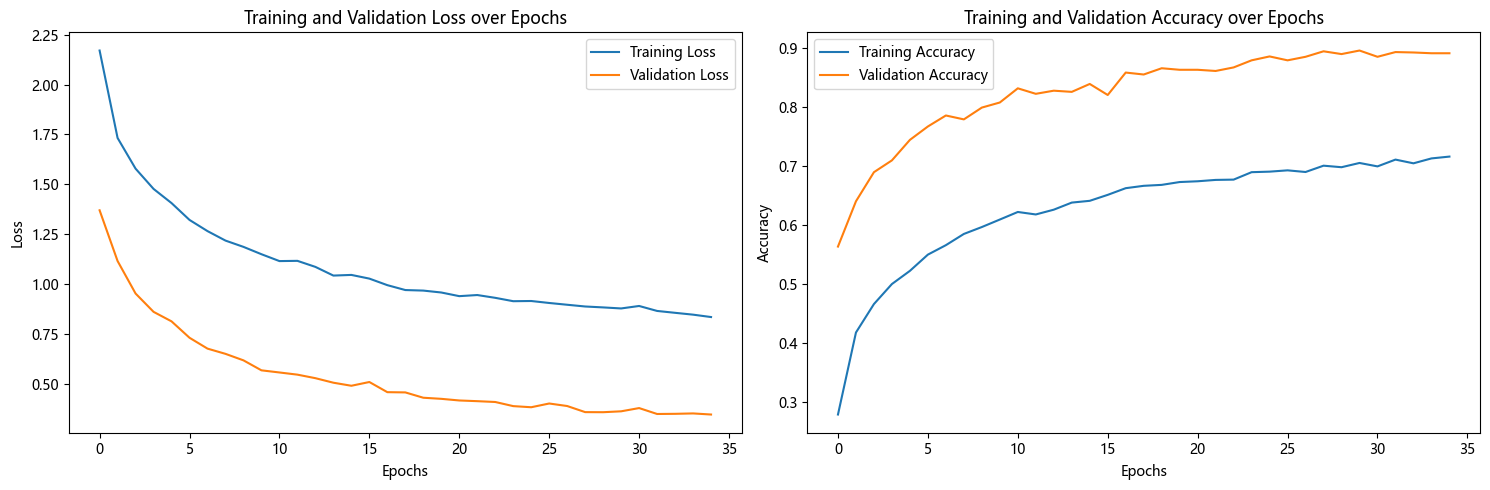

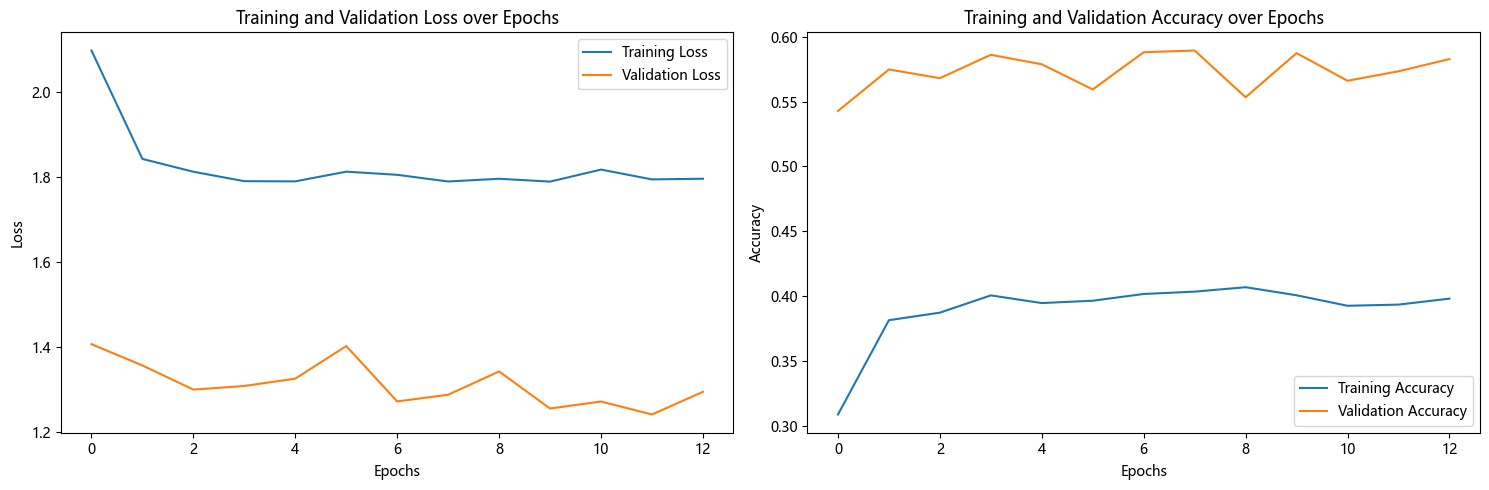

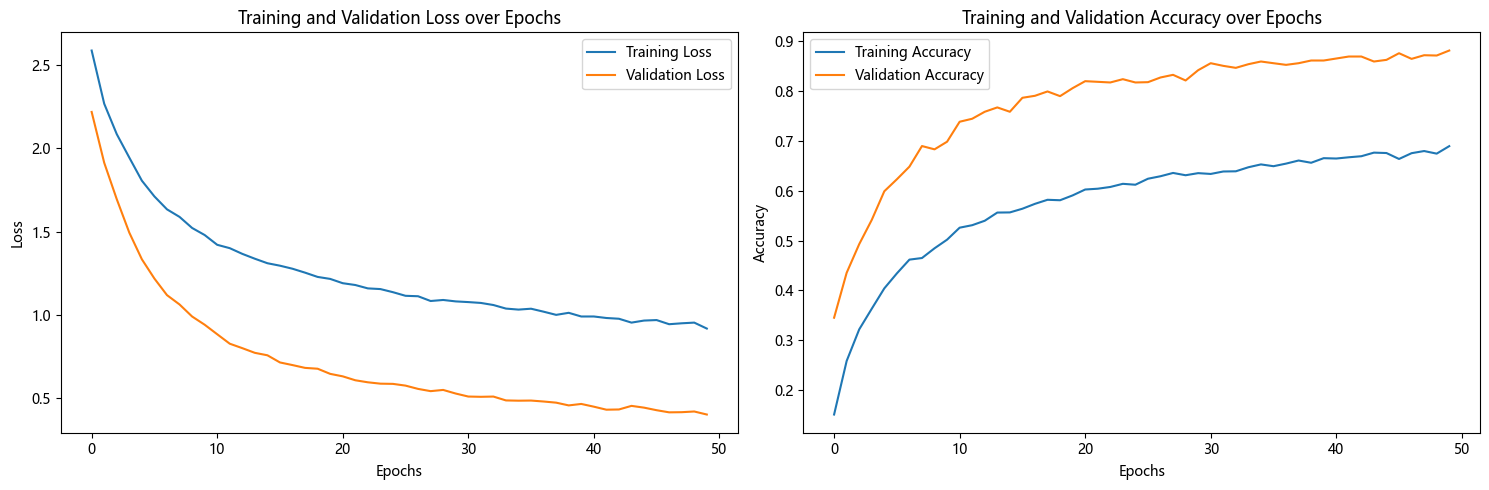

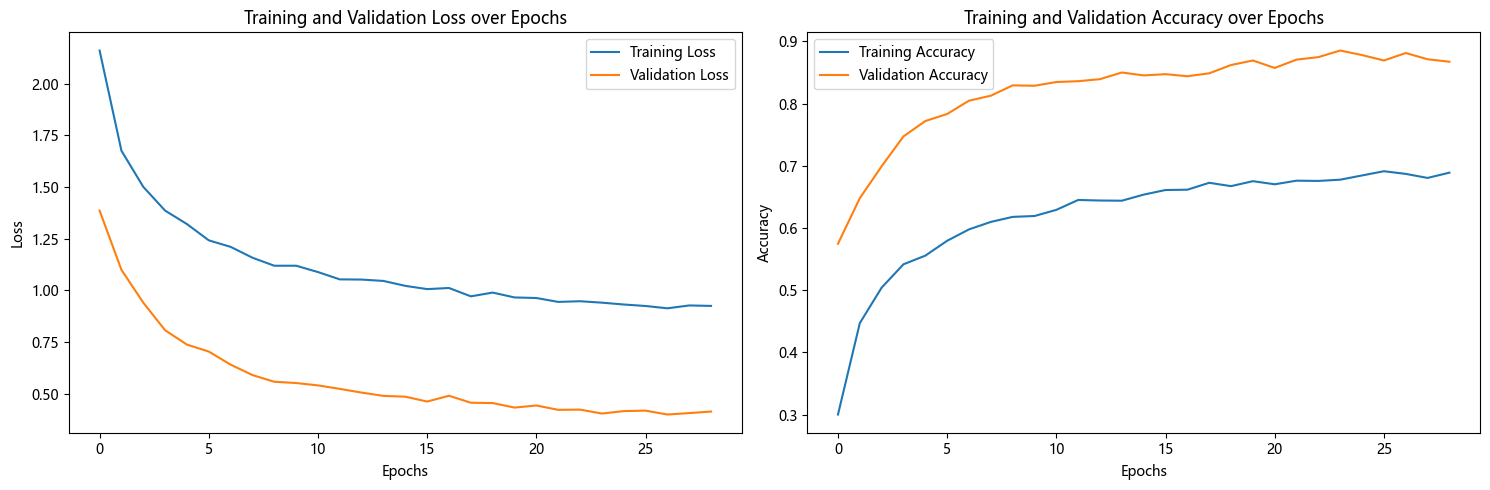

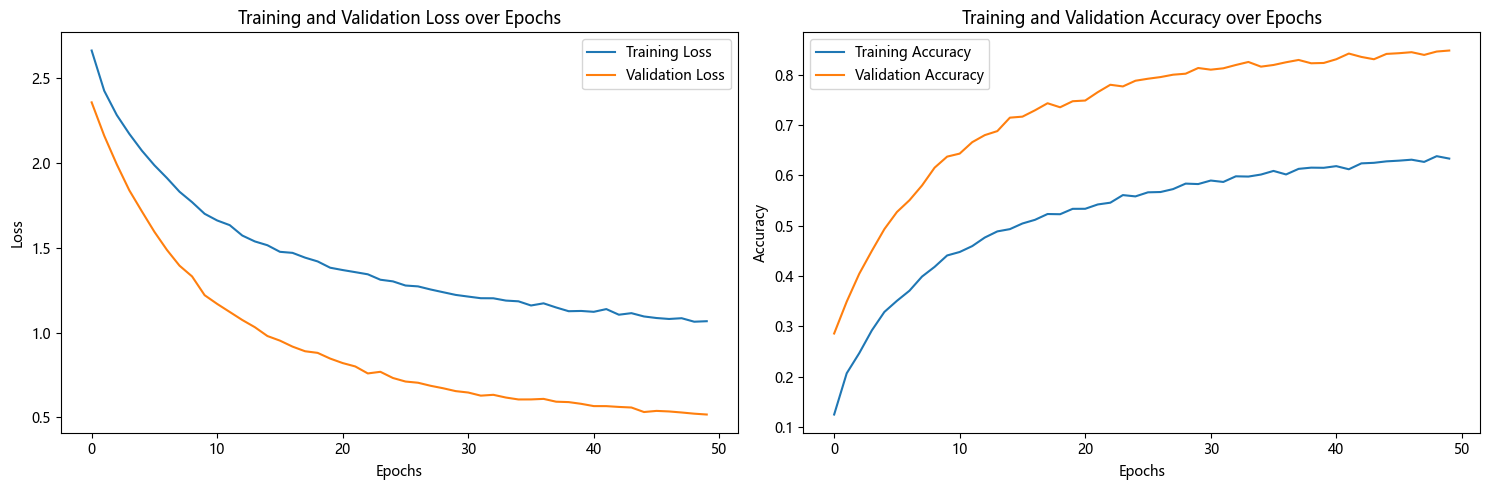

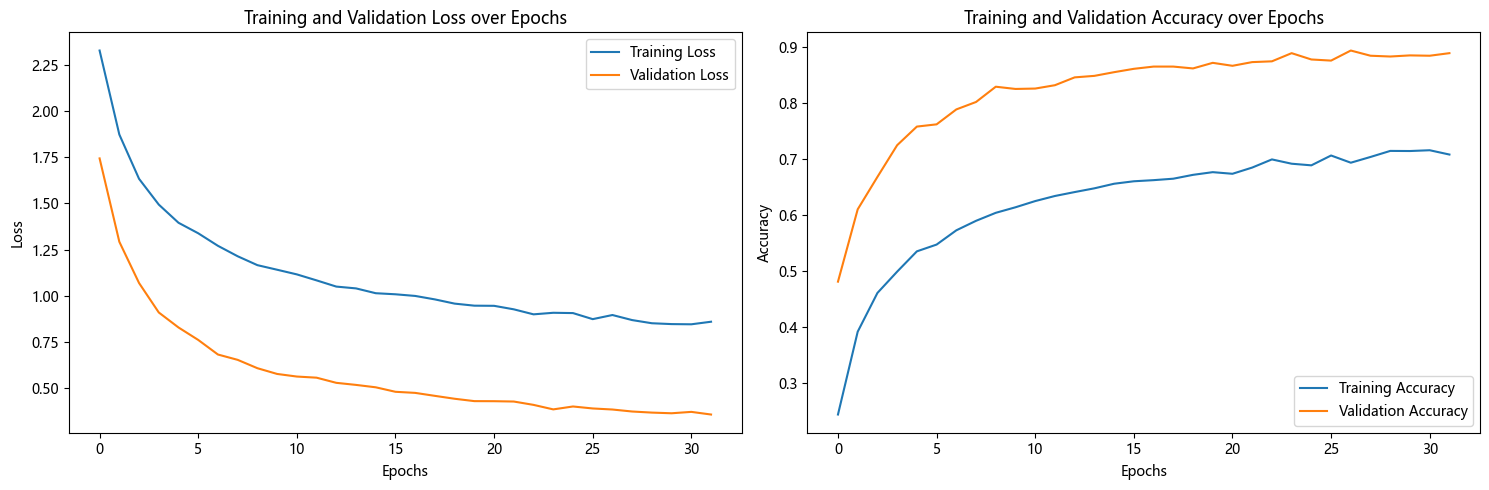

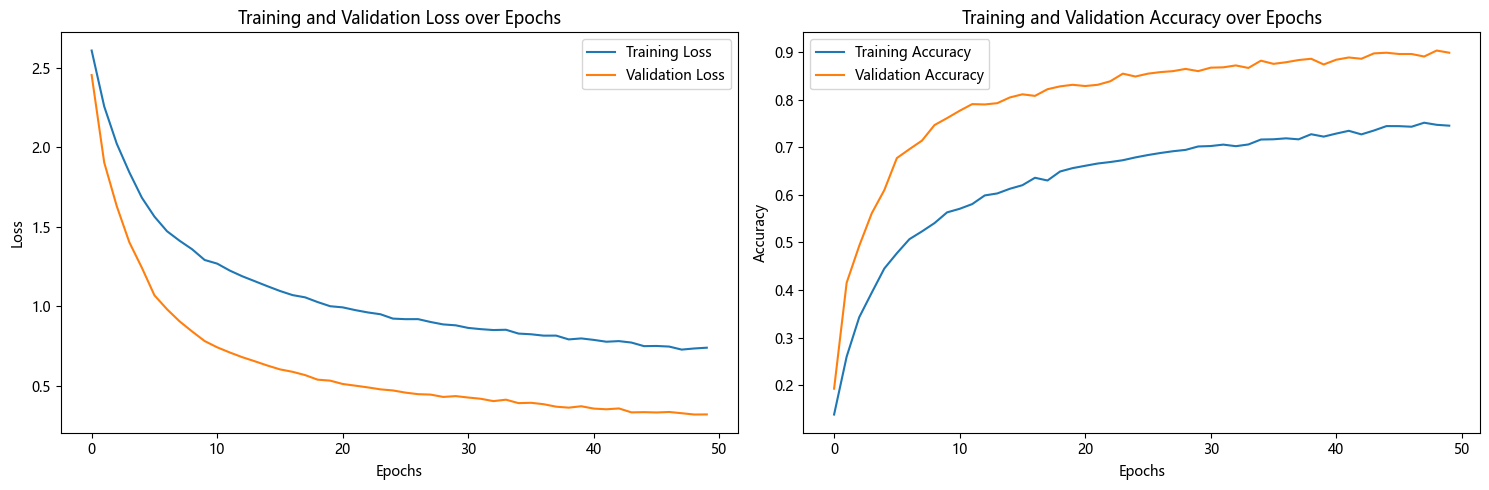

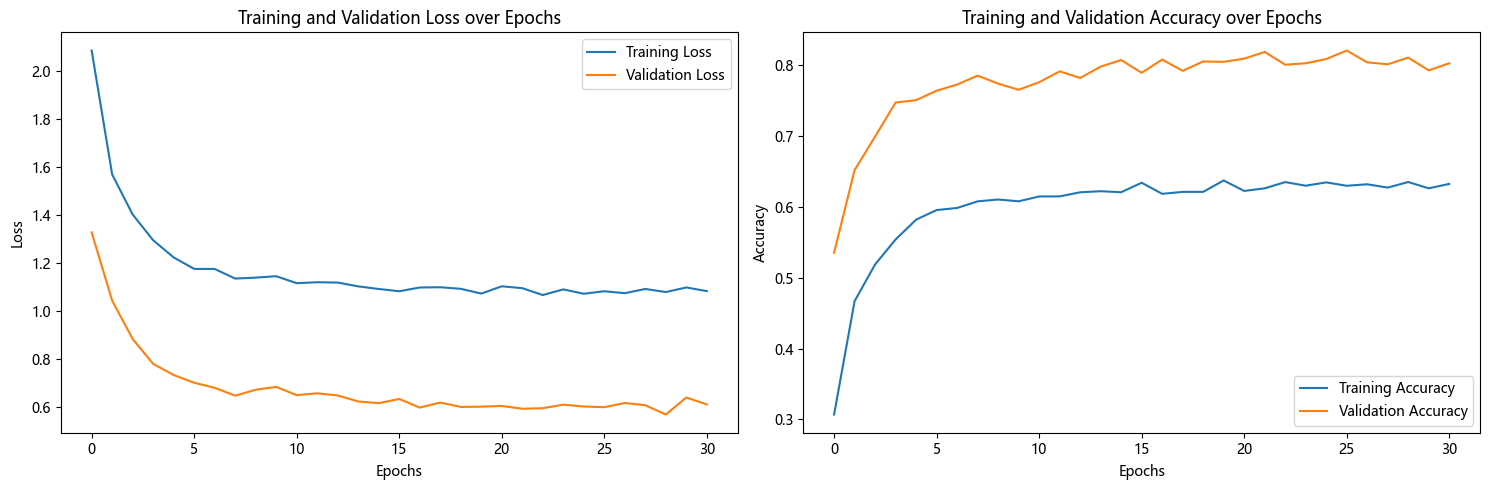

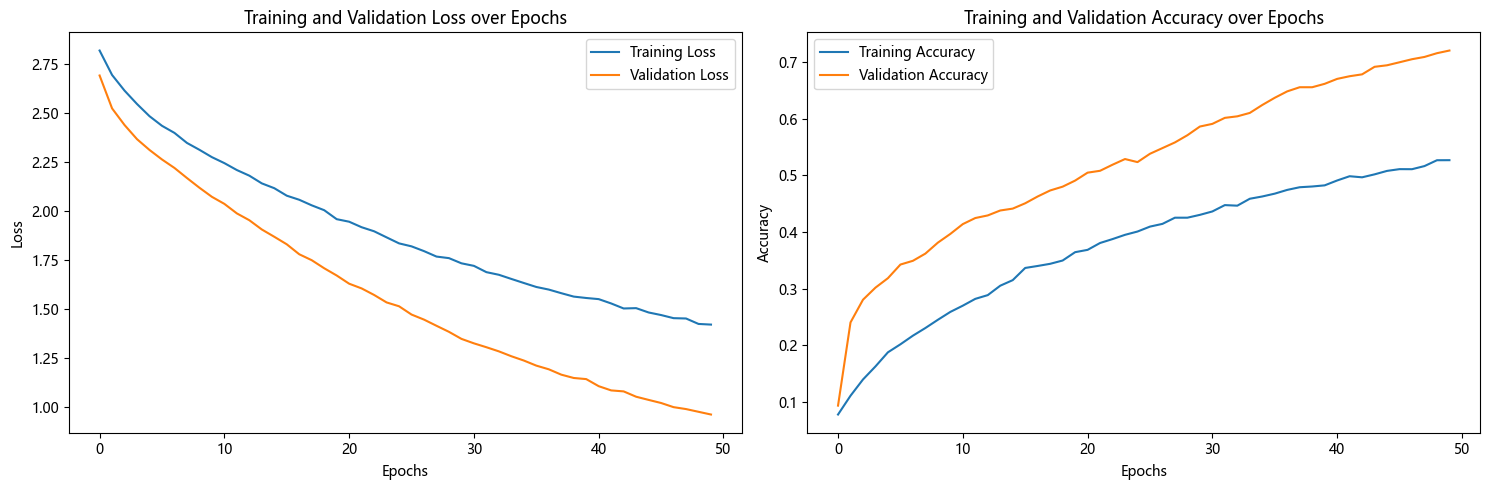

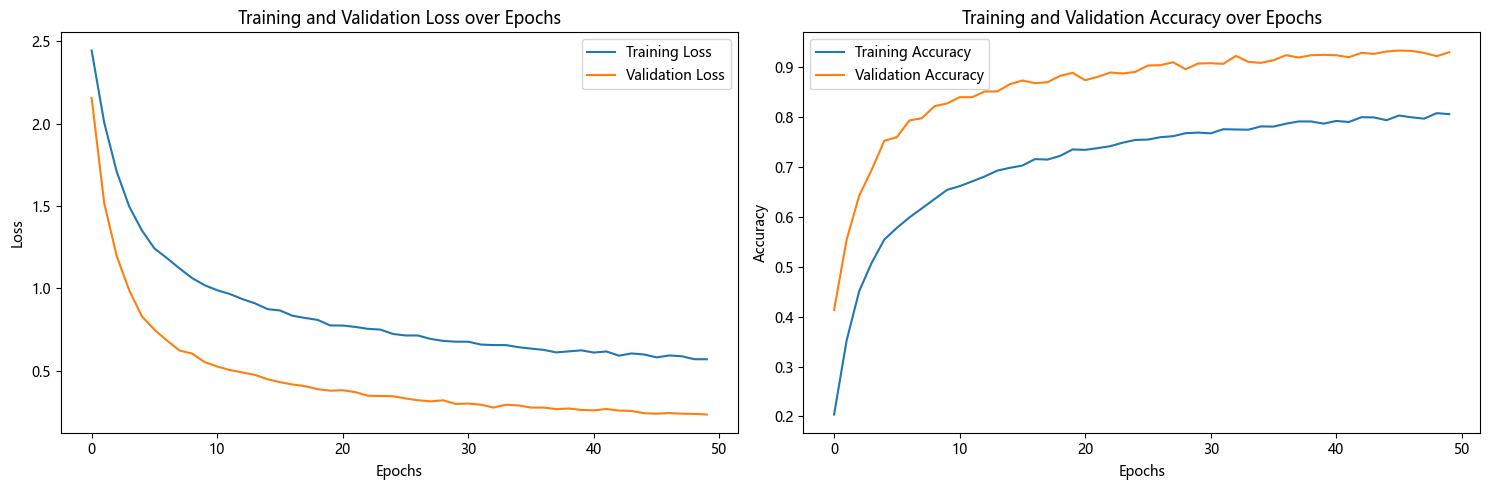

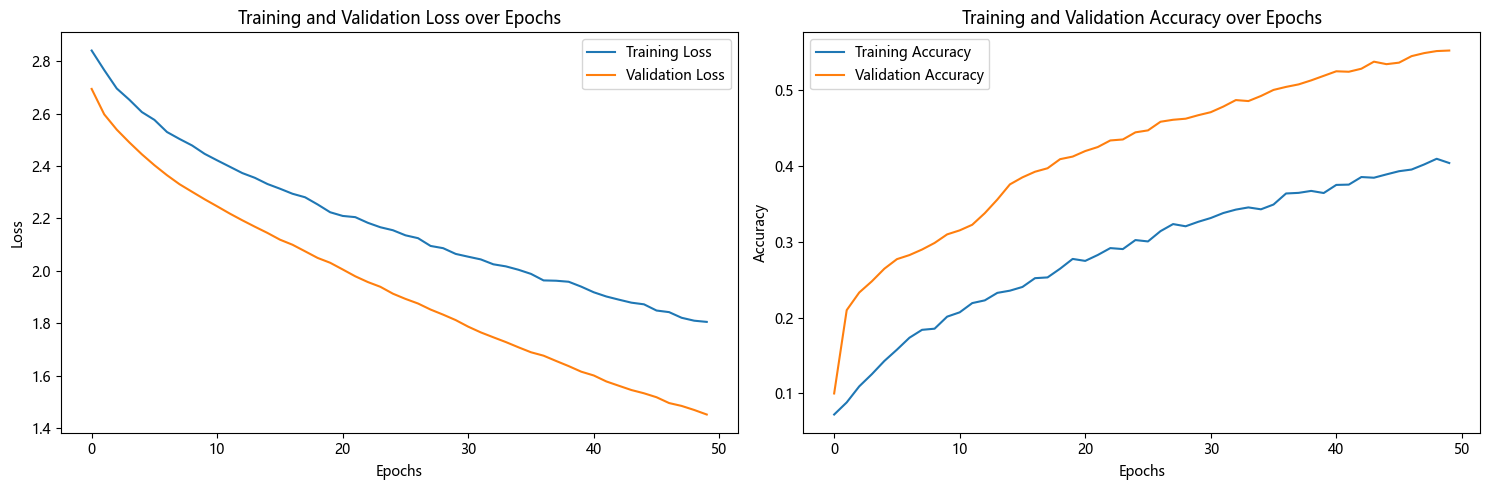

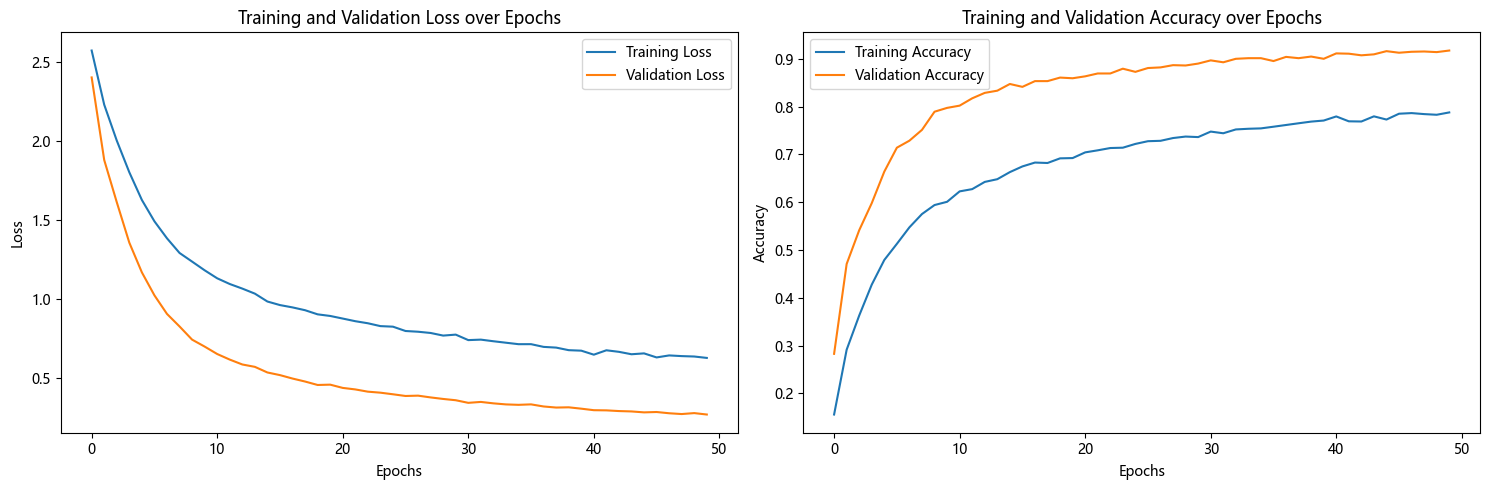

In [20]:
ARCHITECTURE_IDX = 2

for bs in BATCH_SIZE:
    for lr in LEARNING_RATE:
        print(f"\nPlotting training process for batch size {bs} and learning rate {lr} (SGD)")
        plot_training_process(
            total_acc_train_sgd[(bs, lr)],
            total_loss_train_sgd[(bs, lr)],
            total_acc_validation_sgd[(bs, lr)],
            total_loss_validation_sgd[(bs, lr)],
            f"plots/mlp/{architectures[ARCHITECTURE_IDX]['name']}_{bs}_{lr}_sgd.png"
        )

        print(f"\nPlotting training process for batch size {bs} and learning rate {lr} (Adam)")
        plot_training_process(
            total_acc_train_adam[(bs, lr)],
            total_loss_train_adam[(bs, lr)],
            total_acc_validation_adam[(bs, lr)],
            total_loss_validation_adam[(bs, lr)],
            f"plots/mlp/{architectures[ARCHITECTURE_IDX]['name']}_{bs}_{lr}_adam.png"
        )

## 9. Testing

#### Best Model Selection & Parsing

During evaluation we scan `checkpoints/mlp/`, parse filenames using regex to recover:  
`depth`, `hidden_units`, `batch`, `optimizer`, `learning_rate`.  
We then:  
1. Reconstruct the exact MLP architecture.  
2. Evaluate on the test set.  
3. Track the best model by test accuracy (ties can be extended to break on F1).  
4. Plot confusion matrix + training curves for the corresponding run.  
5. Use the same parsed metadata to standardize plot filenames:  
```
plots/mlp/best_model_training_process_{model_name}_{batch}_{lr}_{optimizer}.png
```

In [21]:
pattern_with_opt = re.compile(r"^mlp_(\d+)x([0-9\-]+)_(\d+)_(adam|sgd)_([0-9.]+)\.pth$")
pattern_no_opt = re.compile(r"^mlp_(\d+)x([0-9\-]+)_(\d+)_([0-9.]+)\.pth$")

def parse_checkpoint_filename(fname: str):
    """Parse new MLP checkpoint filename format.

    Returns dict with: depth, units(list[int] or int), batch, optimizer (str|None), lr (float) or None if not parseable.
    """
    m = pattern_with_opt.match(fname)
    if m:
        depth = int(m.group(1))
        units_raw = m.group(2)
        batch = int(m.group(3))
        optimizer = m.group(4)
        lr = float(m.group(5))
    else:
        m2 = pattern_no_opt.match(fname)
        if not m2:
            return None
        depth = int(m2.group(1))
        units_raw = m2.group(2)
        batch = int(m2.group(3))
        optimizer = None
        lr = float(m2.group(4))
    # units pattern may be single int or hyphen separated
    if '-' in units_raw:
        units_list = [int(u) for u in units_raw.split('-') if u]
        hidden_units = units_list
    else:
        hidden_units = int(units_raw)
    return {
        "depth": depth,
        "hidden_units": hidden_units,
        "batch": batch,
        "optimizer": optimizer,
        "lr": lr,
    }

In [22]:
MODELS_DIR = "checkpoints/mlp"

best = {
    "path": None,
    "acc": 0.0,
    "f1": 0.0,
    "cm": None,
    "hidden_layers": None,
    "hidden_units": None,
    "batch_size": None,
    "optimizer": None,
    "learning_rate": None,
}


# Iterate over all .pth files in directory
if os.path.isdir(MODELS_DIR):
    for model_file in os.listdir(MODELS_DIR):
        if not model_file.endswith(".pth"):
            continue
        parsed = parse_checkpoint_filename(model_file)
        if not parsed:
            print(f"Skipping unrecognized filename pattern: {model_file}")
            continue
        model_path = os.path.join(MODELS_DIR, model_file)
        print(f"\nTesting model: {model_path}")
        print(f"  Parsed => depth: {parsed['depth']} hidden_units: {parsed['hidden_units']} batch: {parsed['batch']} optimizer: {parsed['optimizer']} lr: {parsed['lr']}")

        batch_size = parsed['batch']
        # hidden_units may be int or list
        model_hidden_units = parsed['hidden_units']
        model_mlp = MLPBaseline(
            input_dim=INPUT_DIM,
            num_classes=NUM_CLASSES,
            hidden_layers=parsed['depth'],
            hidden_units=model_hidden_units,
        ).to(device)
        model_mlp.load_state_dict(torch.load(model_path, map_location=device))
        model_mlp.eval()

        # Evaluate with correct dataloader
        test_loader = dataloaders_dict.get(batch_size, dataloaders_dict[BATCH_SIZE[0]])["test"]
        test_acc, f1, cm = test_model(model_mlp, test_loader, criterion)
        print(f"Accuracy: {test_acc:.4f} | F1: {f1:.4f}")

        # Update best model
        if test_acc > best["acc"]:
            best.update({
                "path": model_path,
                "acc": test_acc,
                "f1": f1,
                "cm": cm,
                "hidden_layers": parsed['depth'],
                "hidden_units": parsed['hidden_units'],
                "batch_size": parsed['batch'],
                "optimizer": parsed['optimizer'],
                "learning_rate": parsed['lr'],
            })
            print(f"  -> New best model: {model_path} (Acc: {test_acc:.4f}, F1: {f1:.4f})")
else:
    print(f"Models directory not found: {MODELS_DIR}")



Testing model: checkpoints/mlp\mlp_1x512_256_adam_0.0005.pth
  Parsed => depth: 1 hidden_units: 512 batch: 256 optimizer: adam lr: 0.0005
Test Loss: 0.3945 | Test Accuracy: 0.8960 | Macro F1: 0.8959
Accuracy: 0.8960 | F1: 0.8959
  -> New best model: checkpoints/mlp\mlp_1x512_256_adam_0.0005.pth (Acc: 0.8960, F1: 0.8959)

Testing model: checkpoints/mlp\mlp_1x512_256_adam_0.001.pth
  Parsed => depth: 1 hidden_units: 512 batch: 256 optimizer: adam lr: 0.001
Test Loss: 0.3945 | Test Accuracy: 0.8960 | Macro F1: 0.8959
Accuracy: 0.8960 | F1: 0.8959
  -> New best model: checkpoints/mlp\mlp_1x512_256_adam_0.0005.pth (Acc: 0.8960, F1: 0.8959)

Testing model: checkpoints/mlp\mlp_1x512_256_adam_0.001.pth
  Parsed => depth: 1 hidden_units: 512 batch: 256 optimizer: adam lr: 0.001
Test Loss: 0.4004 | Test Accuracy: 0.8933 | Macro F1: 0.8938
Accuracy: 0.8933 | F1: 0.8938

Testing model: checkpoints/mlp\mlp_1x512_256_adam_0.01.pth
  Parsed => depth: 1 hidden_units: 512 batch: 256 optimizer: adam lr

Plot training process and confusion matrix of the best model


Best model: checkpoints/mlp\mlp_3x512-256-128_256_adam_0.001.pth | Acc: 0.9307 | F1: 0.9304


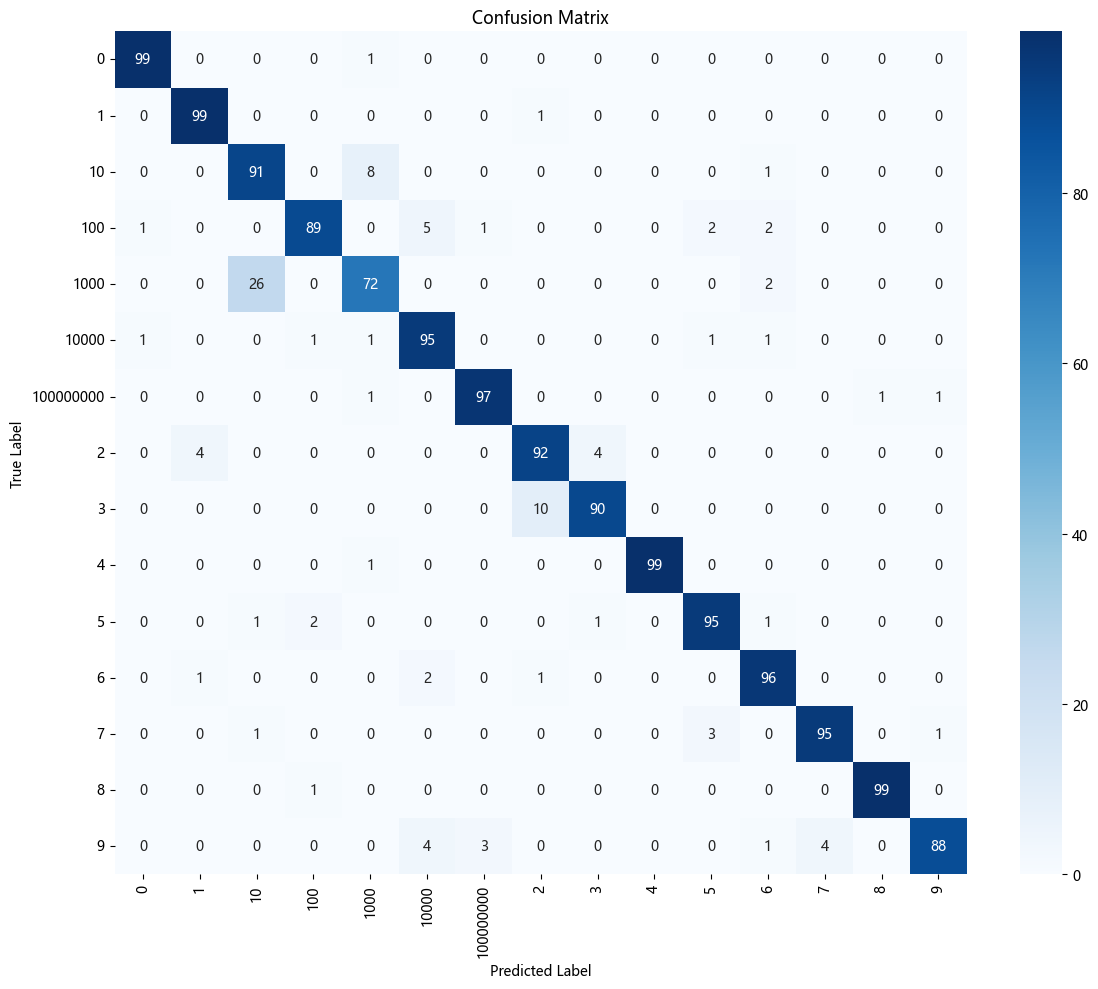

In [23]:
if best["cm"] is not None:
    print(f"\nBest model: {best['path']} | Acc: {best['acc']:.4f} | F1: {best['f1']:.4f}")
    plot_confusion_matrix(best["cm"], datasets["train"].classes)

Model_name: mlp_3x512-256-128 depth: 3 hidden_units: [512, 256, 128] batch: 32 optimizer: adam lr: 0.001
Training process plot saved to plots/mlp/best_model_mlp_3x512-256-128_32_0.001_adam.png
Training process plot saved to plots/mlp/best_model_mlp_3x512-256-128_32_0.001_adam.png


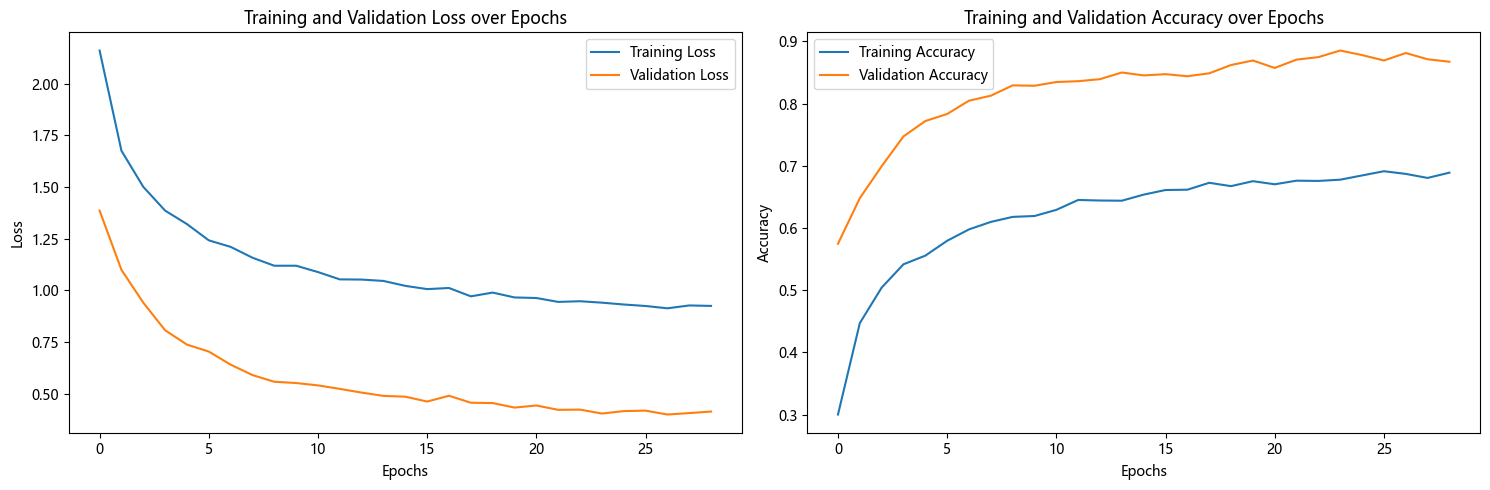

In [24]:
if best["path"] is not None:
    hidden_units = best['hidden_units']
    depth = best['hidden_layers']
    learning_rate = best['learning_rate']
    optimizer = best["optimizer"]
    if isinstance(hidden_units, list):
        if len(set(hidden_units)) == 1:
            units_part = str(hidden_units[0])
        else:
            units_part = '-'.join(str(u) for u in hidden_units)
    else:
        units_part = str(hidden_units)
    model_name = f"mlp_{depth}x{units_part}"

    print(f"Model_name: {model_name} depth: {depth} hidden_units: {hidden_units} batch: {batch_size} optimizer: {optimizer} lr: {learning_rate}")
    key = (batch_size, learning_rate)
    plot_dir = "plots/mlp"
    os.makedirs(plot_dir, exist_ok=True)
    out_path = f"{plot_dir}/best_model_{model_name}_{batch_size}_{learning_rate}_{optimizer}.png"
    if optimizer == "sgd":
        plot_training_process(
            total_acc_train_sgd[key],
            total_loss_train_sgd[key],
            total_acc_validation_sgd[key],
            total_loss_validation_sgd[key],
            out_path
        )
    else:
        plot_training_process(
            total_acc_train_adam[key],
            total_loss_train_adam[key],
            total_acc_validation_adam[key],
            total_loss_validation_adam[key],
            out_path
        )
else:
    print("No best model path available.")

## 10. Inference


1. A single random image is sampled from each class folder under `data/test/` (one representative per class).  
2. The previously selected best model (determined during the testing phase by highest test accuracy, with F1 as an auxiliary metric) is reconstructed with the exact depth and hidden unit pattern parsed from its checkpoint filename.  
3. The model weights are loaded and the model is switched to evaluation mode (`model.eval()`), disabling dropout and other training‑only behaviors.  
4. Each selected image is passed to a `predict_image` helper which:
   - Loads the image from disk.
   - Applies the same preprocessing pipeline used for training (grayscale → resize → tensor → optional flatten).
   - Moves the tensor to the configured device (CPU or GPU).
   - Performs a forward pass to obtain raw logits.
   - Applies `softmax` to convert logits into class probabilities.
   - Returns: (predicted_class_label, probability_vector).
5. The script prints the file path, predicted class, and full probability distribution for inspection.

#### Why One Image Per Class?
Sampling one image per class yields a concise qualitative sanity check—verifying the model is not collapsing onto a small subset of labels and that probabilities are reasonably calibrated across categories.

#### Reproducibility Notes
- Because selection uses `random.choice`, results vary run to run unless a random seed is fixed beforehand.
- If the best model path is missing (e.g., you skipped the training/testing cells), inference is skipped gracefully.

#### Interpreting the Output
- A confident prediction typically shows one probability ≫ others (e.g., >0.85).
- Diffuse probability mass may indicate class ambiguity or insufficient training for that pattern.
- You can aggregate probabilities across many samples to study calibration or create reliability diagrams.

Selected image for prediction: data/test\0\input_78_6_1.jpg


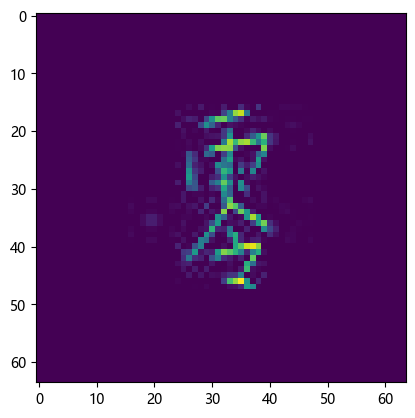

Predicted class: 0 | Probabilities: tensor([[ 10.5790, -10.1721,  -3.4245,   5.1811,  -0.4573,   1.9114,  -5.6376,
         -16.2381, -10.8945,  -0.3410,  -2.9320,  -7.7841,  -6.8558,  -7.5048,
          -1.4019]])
Selected image for prediction: data/test\1\input_66_6_2.jpg


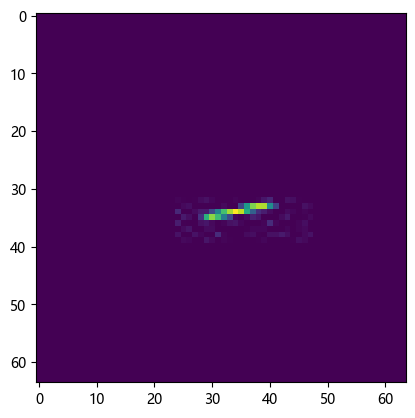

Predicted class: 1 | Probabilities: tensor([[-7.8778,  8.6076, -0.0385, -8.7255, -1.8153, -6.3224, -6.7375,  5.2372,
          1.6367, -3.6561, -5.7534,  0.5353, -0.9068, -2.2729, -7.0764]])
Selected image for prediction: data/test\10\input_38_7_11.jpg


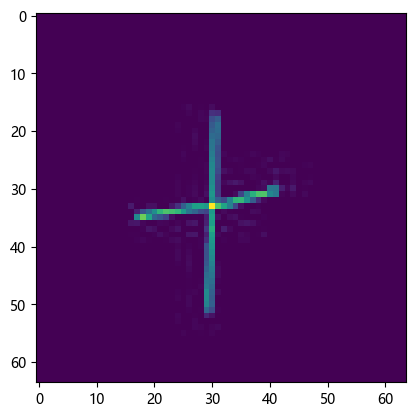

Predicted class: 10 | Probabilities: tensor([[-4.2276, -4.7567,  8.1209, -3.3218,  7.4595, -2.8817, -9.0881, -4.4348,
         -3.7988, -3.7932, -3.1069, -1.8666, -0.9126, -4.9544, -6.0651]])
Selected image for prediction: data/test\100\input_86_8_12.jpg


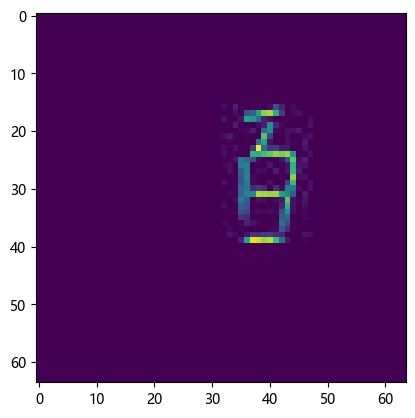

Predicted class: 100 | Probabilities: tensor([[ 0.5970, -9.2708, -1.2538,  4.6944,  0.9841,  2.6230, -4.7470, -7.0731,
         -4.2026, -0.6049,  1.8301, -3.4264, -2.7721, -5.3685, -1.7680]])
Selected image for prediction: data/test\1000\input_86_2_13.jpg


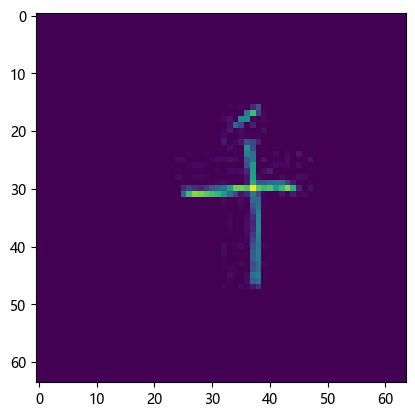

Predicted class: 10 | Probabilities: tensor([[-4.4597, -3.0104,  8.2400, -3.8273,  5.9842, -2.4377, -9.3280, -4.1090,
         -5.0399, -3.7657, -3.7391, -2.2968, -0.1227, -3.7524, -5.8388]])
Selected image for prediction: data/test\10000\input_11_7_14.jpg


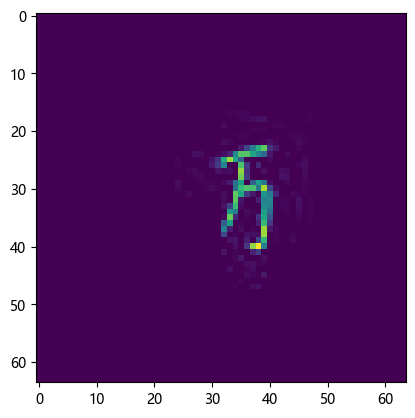

Predicted class: 10000 | Probabilities: tensor([[-0.2362, -7.8712, -1.6902,  1.9988, -1.2147,  4.5243, -3.2808, -7.6869,
         -6.1443, -2.1243, -0.7989, -0.1498, -2.0065, -1.8169,  1.2047]])
Selected image for prediction: data/test\100000000\input_87_9_15.jpg


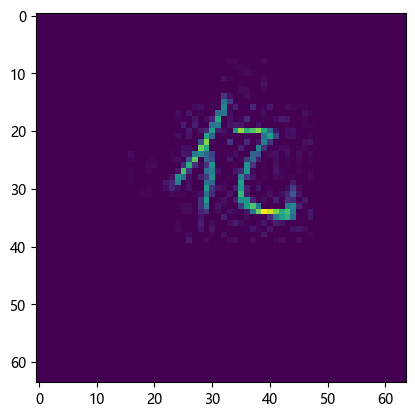

Predicted class: 100000000 | Probabilities: tensor([[-4.4205, -7.3671, -7.1549, -1.7184, -5.0103, -1.9052,  6.5276, -4.9589,
         -5.9110,  1.0502, -2.7755, -1.7937,  0.3724, -0.3755,  3.3812]])
Selected image for prediction: data/test\2\input_21_7_3.jpg


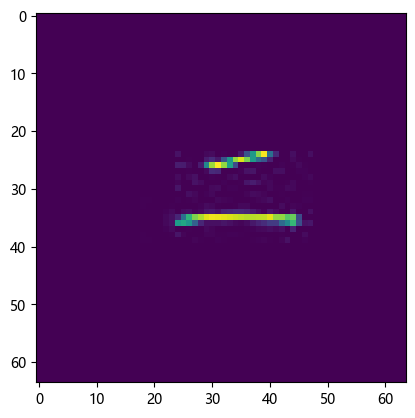

Predicted class: 2 | Probabilities: tensor([[-13.2970,   2.8618,  -5.9180,  -9.5566,  -2.8387,  -8.9473,  -6.9827,
          10.0611,   7.7846,  -5.5691,  -0.8131,  -0.0328,  -0.2421,  -7.4300,
          -7.8365]])
Selected image for prediction: data/test\3\input_9_7_4.jpg


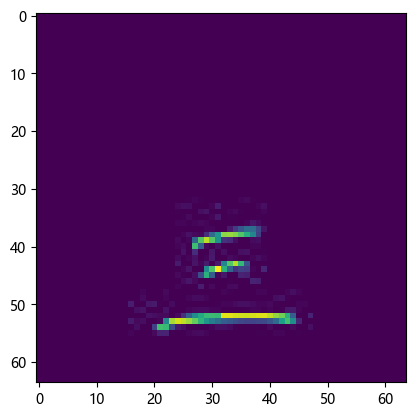

Predicted class: 3 | Probabilities: tensor([[-7.9118, -2.8669, -5.3733, -4.6077, -0.8905, -5.0460, -4.9609,  3.8354,
          6.9722, -5.4411,  1.0866,  0.7770, -0.2732, -7.3573, -3.5752]])
Selected image for prediction: data/test\4\input_19_4_5.jpg


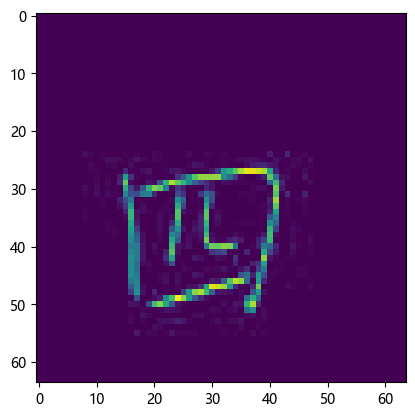

Predicted class: 4 | Probabilities: tensor([[-2.7270, -5.5608, -4.9531,  0.3017, -3.0701, -0.9698,  0.1977, -5.5191,
         -7.2387,  7.5314, -2.7380, -2.9377, -3.3746, -5.5771, -2.9745]])
Selected image for prediction: data/test\5\input_75_1_6.jpg


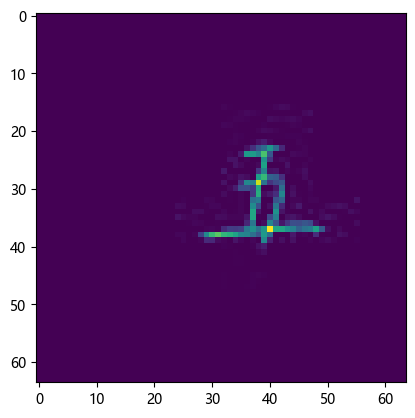

Predicted class: 5 | Probabilities: tensor([[-5.5589, -9.0747, -4.4738,  1.2473, -0.5582, -1.5209, -4.1852, -3.0644,
         -0.1830, -1.1042,  6.0516, -4.1892,  0.2511, -8.7445, -1.0436]])
Selected image for prediction: data/test\6\input_84_3_7.jpg


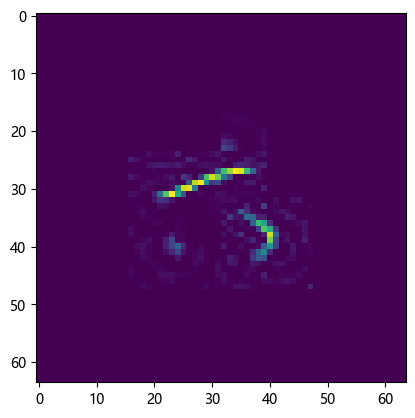

Predicted class: 6 | Probabilities: tensor([[-5.3129,  0.1632, -1.0269, -6.4292, -1.1627, -1.2110, -5.1275, -0.4457,
         -1.6481, -4.3094, -6.1281,  4.7877, -1.0359, -0.6871, -2.1248]])
Selected image for prediction: data/test\7\input_19_5_8.jpg


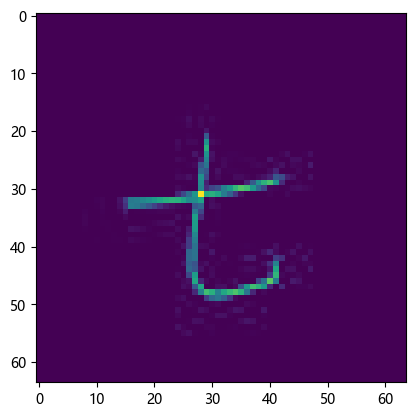

Predicted class: 7 | Probabilities: tensor([[-7.1149, -5.8751, -1.7310, -4.0839, -2.1783, -4.0872, -2.0337, -2.6028,
         -2.4348, -4.6927, -1.6326, -1.2337,  6.6719, -6.4670,  1.2018]])
Selected image for prediction: data/test\8\input_12_5_9.jpg


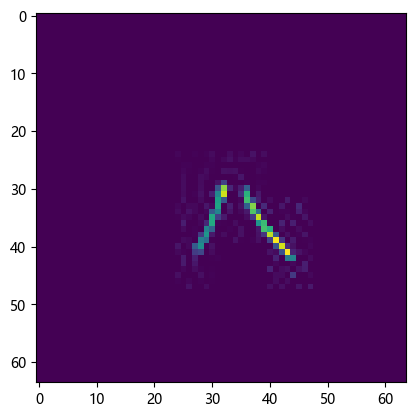

Predicted class: 8 | Probabilities: tensor([[-7.7361, -4.3295, -4.9061, -4.7383, -4.5246, -0.9941,  2.5123, -2.5852,
         -5.3479, -3.8248, -5.6488,  2.3625, -3.0108, 10.5820,  0.9426]])
Selected image for prediction: data/test\9\input_96_4_10.jpg


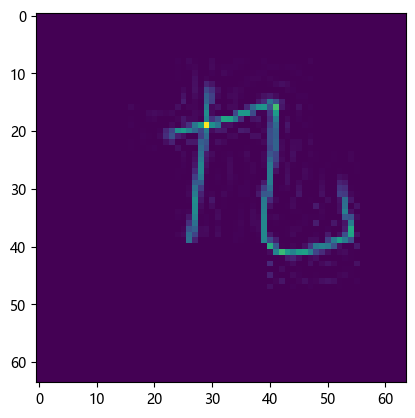

Predicted class: 100000000 | Probabilities: tensor([[-4.1339, -7.0428, -5.5508, -1.5755, -4.4765,  0.0524,  4.1350, -5.3997,
         -6.0660, -0.0480, -2.8007, -0.2129,  0.6748, -0.7350,  3.7015]])


In [27]:
# Collect one random image per class folder in data/test

TEST_ROOT = "data/test"
selected_images = []
for cls in sorted(os.listdir(TEST_ROOT)):
    cls_dir = os.path.join(TEST_ROOT, cls)
    if not os.path.isdir(cls_dir):
        continue
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg",))]
    if not imgs:
        continue
    selected = os.path.join(cls_dir, random.choice(imgs))
    selected_images.append(selected)

if best["path"]:
    mlp_model = MLPBaseline(INPUT_DIM, NUM_CLASSES, hidden_layers=best['hidden_layers'], hidden_units=best['hidden_units']).to(device)
    mlp_model.load_state_dict(torch.load(best["path"], map_location=device))
    mlp_model.eval()

    mlp_model.load_state_dict(torch.load(best["path"]))

    for img_path in selected_images:
        print(f"Selected image for prediction: {img_path}")
        prediction, probs = predict_image(
            model=mlp_model,
            image_path=img_path,
            class_names=datasets['train'].classes,
            device=device,
        )
        print(f"Predicted class: {prediction} | Probabilities: {probs}")
        print("-" * 40)
else:
    print("No best model available; skipping inference.")